In [72]:
import csv
import sys
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime
import pickle
from scipy import signal
import matplotlib.gridspec
import tilt
sys.path.insert(1,'tilt/')
from PCA_projection_tilt import *
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['svg.fonttype'] = 'none'
path_figs = 'paper_figs/'
golden_ratio =  1.618
onepltsize = (golden_ratio*2.5,2.5)
path_tilt_paper = 'tmp/'
date_initial_str = '2018-05-01'
date_final_str = '2018-08-05'
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every day
date_fmt = mdates.DateFormatter('%m/%d')
date_initial_plot = mdates.date2num(datetime.strptime('2018-05-01','%Y-%m-%d'))
date_initial_volumes = mdates.date2num(datetime.strptime('2018-05-01','%Y-%m-%d')) #for GLISTEN volume
date_final_plot = mdates.date2num(datetime.strptime('2018-08-05','%Y-%m-%d'))
date_eruption = mdates.date2num(datetime.strptime('2018-05-04','%Y-%m-%d'))
date_eruption_end = mdates.date2num(datetime.strptime('2018-08-04','%Y-%m-%d'))
date_explosion1 = mdates.date2num(datetime.strptime('2018-05-16','%Y-%m-%d'))
date_explosion2 = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_intensity_eruption = mdates.date2num(datetime.strptime('2018-05-18','%Y-%m-%d'))
date_caldera_start = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_caldera_end = mdates.date2num(datetime.strptime('2018-08-02','%Y-%m-%d'))
date_caldera_broad = mdates.date2num(datetime.strptime('2018-06-20','%Y-%m-%d'))


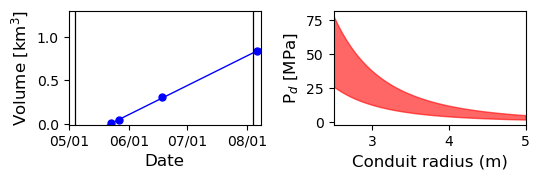

In [3]:
model_ERZ = LinearRegression()
model_summit = LinearRegression()


A = np.loadtxt('volumes.txt')
summit = A[0:4,:]
ERZ = A[4:,:]
t_summit = summit[:,0]
t_summit = date_initial_volumes - 1 + t_summit
vol_summit = -summit[:,1]/1e+9
eb_summit = summit[:,2]
t_ERZ = ERZ[:,0]
t_ERZ = date_initial_volumes - 1 + t_ERZ
vol_ERZ = ERZ[:,1]/1e+9
t_ERZ = t_ERZ.reshape(-1,1)
t_summit = t_summit.reshape(-1,1)

vol_ERZ = vol_ERZ.reshape(-1,1)
vol_summit = vol_summit.reshape(-1,1)

model_ERZ.fit(t_ERZ, vol_ERZ)
model_summit.fit(t_summit, vol_summit)

tfit = np.linspace(date_initial_volumes+3,date_initial_volumes+3+99)
vol_ERZ_fit = model_ERZ.predict(tfit[:, np.newaxis])
vol_summit_fit = model_summit.predict(tfit[:, np.newaxis])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5.5,1.9))
ax[0].plot(t_summit,vol_summit ,'bo',markersize = 5,linewidth = 1)
#ax[0]plot(t_ERZ,vol_ERZ ,'ro',markersize = 7,linewidth = 1 )
#ax[0]plot(tfit,vol_ERZ_fit,'r',linewidth = 1)
ax[0].plot(tfit,vol_summit_fit,'b',linewidth = 1)
ax[0].tick_params(labelsize = 10)
ax[0].set_xlabel('Date',fontsize= 12)
ax[0].set_ylabel('Volume [km$^3$]',fontsize= 12)
ax[0].set_ylim([-0.01,1.3])
ax[0].set_xlim(date_initial_plot,date_final_plot + 3)
ax[0].xaxis.set_major_formatter(date_fmt)
ax[0].xaxis.set_major_locator(months)
ax[0].axvline(x=date_eruption,color = 'black',linewidth = 0.9)
ax[0].axvline(x=date_eruption_end,color = 'black',linewidth = 0.9)

pi = 3.14
a = np.linspace(2.5,5)
S = pi * a**2 
ar = np.linspace(10,100,4)
mu1 = 1e+2
mu2 = 3e+2
l = 4e+4
q = 1e+2
P1 = q * 8 * mu1 * l * pi/ (S**2)/1e+6
P2 = q * 8 * mu2 * l * pi/ (S**2)/1e+6

ax[1].fill_between(a,P1,P2,color = 'red',alpha=0.6)
ax[1].set_xlabel('Conduit radius (m)',fontsize= 12)
ax[1].set_ylabel('P$_d$ [MPa]',fontsize= 12)
ax[1].set_xlim([2.5,5])
ax[1].tick_params(labelsize = 10)

plt.savefig(path_figs + 'Fig1_preliminary.svg')
plt.savefig(path_figs + 'Fig1_ppreliminary.pdf')
plt.tight_layout()
plt.show()

In [4]:
def read_csv(filename):
  
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        A = []
        for row in readCSV:
            A.append(row)
    return A
def format_tilt(A):
    A = A[4:]
    t = []
    d = []
    for i in A:
        t.append(float(i[0]))
        d.append(float(i[1]))
    t = np.array(t)
    d = np.array(d)
    return t,d
def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end

stations = pickle.load(open('tilt/tilt_dictionary_01may.pickle','rb'))
b, a = signal.butter(2, 0.03)
name = 'UWD'
east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]
index,start,end = get_data_segment(date_initial_str,date_final_str,time)
east = east[index]
north = north[index]
time = time[index]
east = (east - east[0]) 
north = (north - north[0])
time = time[::1]
north = north[::1]
east = east[::1]
time = time - time[0]
u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
proj_max = east * u1 + north * w1
proj_max = signal.filtfilt(b, a, proj_max)
tilt = proj_max[:]
fig = plt.figure(constrained_layout=True, figsize = (7,4))
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[0, :2])
ax0.plot(time,tilt)
ax0.set_xlim([0,96])
ax0.set_ylabel('UWD [$\mu$rad]',fontsize= 12)
data = read_csv(path_tilt_paper + 'reunion_seis.csv')
days,tilt = format_tilt(data)
tilt = tilt[np.argsort(days)]
days = days[np.argsort(days)]

#days = days - days[0]
tilt = tilt - tilt[0]
ax1 = fig.add_subplot(gs[1, :2])
ax1.plot(days,tilt)
ax1.set_xlim([4,14.5])
ax1.set_ylim([-0.87,-0.10])
ax1.tick_params(labelsize = 10)
ax1.set_ylabel('RER [$\mu$rad]',fontsize= 12)
data = read_csv(path_tilt_paper + 'myake_data.csv')
days,tilt = format_tilt(data)

#days = days - days[0]
tilt = tilt - tilt[0]
tilt = tilt[np.argsort(days)]
days = days[np.argsort(days)]
tilt = - tilt
ax2 = fig.add_subplot(gs[2, :2])
ax2.plot(days,tilt)
ax2.set_xlabel('Days',fontsize= 12)
ax2.set_ylabel('MKS [$\mu$rad]',fontsize= 12)
ax2.set_xlim([0,33])
ax2.set_ylim([-55,-10])
fig.align_ylabels([ax0,ax1,ax2])
plt.savefig(path_figs + 'Tilt_Examples.pdf')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'tilt/tilt_dictionary_01may.pickle'

In [ ]:
left_date = mdates.date2num(datetime.strptime('2018-07-18','%Y-%m-%d'))
right_date = mdates.date2num(datetime.strptime('2018-07-22','%Y-%m-%d'))
proj_zoom = proj_max[ np.logical_and(time > left_date, time < right_date)] 
time_zoom = time[ np.logical_and(time > left_date, time < right_date)]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time_zoom,proj_zoom  - proj_zoom[0],linewidth = 3,color ='orange')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
plt.savefig(path_figs + 'zoom.pdf')

In [ ]:
from scipy.interpolate import interp1d
def stick_slip(tilt_filt,dates,cald_start,station):
    if station == 'SDH':
        dist = 400
        prom = 7
    else:
        dist = 500
        prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
    min_peaks = []
    time_min_peaks = []
    for i in range(len(ind)-1):
        y = tilt_filt[ind[i]:ind[i+1]]
        x = dates[ind[i]:ind[i+1]]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
    print(ind)
    if len(ind)>0:
        y = tilt_filt[ind[-1]:]
        x = dates[ind[-1]:]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        peaks = np.array(peaks)
        min_peaks =np.array(min_peaks[:-1])
        time_min_peaks = np.array(time_min_peaks[:-1])
        time_peaks = np.array(time_peaks)
        min_peaks = min_peaks[time_min_peaks > cald_start]
        time_min_peaks = time_min_peaks[time_min_peaks > cald_start]
        peaks = peaks[time_peaks > cald_start]
        time_peaks = time_peaks[time_peaks > cald_start]
        amp = peaks[1:] - min_peaks
        print('Number of collapses: ',len(time_peaks))

    else:
        amp = 0
    print('Mean inflation event of station ', station,' is ', np.mean(amp))

    return np.diff(time_min_peaks),time_min_peaks[:-1],amp,min_peaks

name = 'UWD'
dt_stick,time_collapses,amplitude,min_collapse = stick_slip(proj_max,time,date_caldera_start,name)
model_GPS = LinearRegression()

amplitude = amplitude[:-1]
nCollapses = np.arange(1,len(dt_stick)+1)
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (8,10))
event_steady = 10
ax[0].plot(nCollapses,min_collapse[:-1] - min_collapse[0],'bo')
ax[0].plot(nCollapses,min_collapse[:-1] - min_collapse[0],'b')
ax[0].tick_params(labelsize = 14)
ax[0].set_ylabel('Deflation [$\mu$rad]',fontsize =14)


ax[1].axhline(np.mean(amplitude[event_steady:]))
ax[1].plot(nCollapses,amplitude,'ro')
ax[1].plot(nCollapses,amplitude,'r')
ax[1].tick_params(labelsize = 14)
ax[1].set_ylabel('Inflation  [$\mu$rad]',fontsize =14)

ax[2].plot(nCollapses,dt_stick,'go')
ax[2].plot(nCollapses,dt_stick,'g')
ax[2].tick_params(labelsize = 14)
ax[2].set_ylabel('$\Delta$t collapses [days]',fontsize = 14)


ax[2].set_ylabel('$\Delta$t collapses [days]',fontsize = 14)
gps_list = ['CALS.csv']
for gps in gps_list:
    data = read_csv(path_GPS + gps)
    time_gps,date,disp = format_gps(data)
    date_new = []
    for line in date:
        date_temp = line[:10]
        date_new.append(mdates.date2num(datetime.strptime(date_temp,'%Y-%m-%d')))
    date_gps = np.array(date_new)
nCollapses = nCollapses[time_collapses>= date_gps[0]]
time_collapses = time_collapses[time_collapses>= date_gps[0]]
f = interp1d(date_gps,disp)
disp_interp = f(time_collapses)
ax[3].plot(nCollapses,disp_interp -  disp_interp[0],color = 'yellow')
ax[3].plot(nCollapses,disp_interp - disp_interp[0],'o',color = 'yellow' )
ax[3].tick_params(labelsize = 14)
ax[3].set_ylabel('CALS [m]',fontsize = 14)
ax[3].set_xlabel('Collapse number',fontsize = 20)
ax[3].set_xlim([0,52])
fig.align_ylabels(ax[:])
plt.savefig(path_figs + 'tilt_variables.pdf')
print('diff_collapses',np.diff(min_collapse))


In [ ]:
plt.hist(np.diff(min_collapse),10)

In [25]:
##### from netCDF4 import Dataset
import gdal
from sklearn.decomposition import PCA
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LightSource
import pickle 

def crop_dem(array,lat_orig,lon_orig,lat_min,lat_max,lon_min,lon_max):
    array = array[(lat_orig >= lat_min) & (lat_orig <= lat_max),:]
    array = array[:,(lon_orig >= lon_min) & (lon_orig <= lon_max)]
    return array, lat_orig[(lat_orig >= lat_min) & (lat_orig <= lat_max)],lon_orig[(lon_orig >= lon_min) & (lon_orig <= lon_max)]

def draw_vector(v0, v1,cl, head =0,ax=None,):
    #Draws a vector with no arrow using annotation. v0 and v1 are two vectors containing the coordinates of the starting point of the arrow (v0)
    #and the final point of the arrow (v1)
    ax = ax or plt.gca()
    if head:
        arrowprops=dict(arrowstyle = '->, head_width=0.3, head_length=0.5',color= cl,
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    else:
        arrowprops=dict(arrowstyle='-',color= cl,
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def PCA_vectors(x,y):
    '''
    extract principal vectors of PCA, always careful to how the vectors components are returned.
    '''
    pca = PCA(n_components=2)
    data = np.zeros((len(x),2))
    data[:,0] = x
    data[:,1] = y
    out_pca = pca.fit(data)
    umax = out_pca.components_[0,0] #First component of the vectors associated to the maximum variance
    wmax = out_pca.components_[0,1]#Second component of the vectors associated to the maximum variance
    umin = out_pca.components_[1,0] #First component of the vectors associated to the least variance
    wmin = out_pca.components_[1,1] #Second component of the vectors associated to the least variance
    return umax,wmax,umin,wmin,out_pca.mean_

def remove_value(x,y,val1,val2,par,cond):
    #Remove from vector val1 and its coordinate z,y entries that are in the val1 array according to par in the val2 array
    if cond == 'gt':
        x =  x[val2 > par]
        y = y[val2 > par]
        val1 = val1[val2 > par]
    else:
        x =  x[val2 < par]
        y = y[val2 < par]
        val1 = val1[val2 < par]
    return x,y,val1


verticalEx = 0.1    
ls = LightSource(azdeg=135, altdeg=30)

path_data_sar  = 'data/sar/'

lat_minimum = 19.31
lat_maximum = 19.48
lon_minimum = -155.40
lon_maximum = -155.15

lat_minimum_DEM = 19.31
lat_maximum_DEM = 19.48
lon_minimum_DEM = -155.40
lon_maximum_DEM = -155.15

coherence_thresh = 0.5
list_station =  ['UWD','SDH','IKI']
stations = pickle.load(open('tilt/tilt_dictionary_20june.pickle','rb')) 

step_down = 5 #Donwn sample parameter 

filename = 'S1-GUNW-D-R-087-tops-20180622_20180529-161541-20480N_18471N-PP-652b-v2_0_1.nc'
rootgrp = Dataset(path_data_sar + filename,'r')
data= rootgrp['science/grids/data/']
geometry = rootgrp['science/grids/imagingGeometry/']
wavelength = np.float64(rootgrp['science/radarMetaData'].variables['wavelength'][:])
lonMeta = geometry.variables['longitudeMeta'][:]
latMeta = geometry.variables['latitudeMeta'][:]
heightsMeta = geometry.variables['heightsMeta'][:]
heightsMeta = heightsMeta[:]
incidence = geometry.variables['incidenceAngle'][:]
look = geometry.variables['lookAngle'][:]
azimuth = geometry.variables['azimuthAngle'][:]
lon_sar = data.variables['longitude'][:]
lat_sar = data.variables['latitude'][:]
phase = data.variables['unwrappedPhase'][:]
coh = data.variables['coherence'][:]

#Cropping
phase_cropped = phase[(lat_sar > lat_minimum) & (lat_sar < lat_maximum),:]
phase_cropped = phase_cropped[:, (lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
coh_cropped = coh[(lat_sar > lat_minimum) & (lat_sar < lat_maximum),:]
coh_cropped = coh_cropped[:, (lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
lat_sar_cropped = lat_sar[(lat_sar > lat_minimum) & (lat_sar < lat_maximum)]
lon_sar_cropped = lon_sar[(lon_sar > lon_minimum) & (lon_sar < lon_maximum)]
phase = phase_cropped[:]
coh = coh_cropped[:]
lat = lat_sar_cropped[:]
lon = lon_sar_cropped[:]

#Downsampling
phase_downsamp = phase[::step_down,::step_down]
coh_downsamp = coh[::step_down,::step_down]
lat_downsamp = lat[::step_down]
lon_downsamp = lon[::step_down]

#Vectorizing
LON,LAT = np.meshgrid(lon,lat)
lon = LON.reshape(1,LON.size)
lat = LAT.reshape(1,LAT.size)
phase = phase.reshape(1,phase.size)
coh = coh.reshape(1,coh.size)
LON,LAT = np.meshgrid(lon_downsamp,lat_downsamp)
lon_downsamp = LON.reshape(1,LON.size)
lat_downsamp = LAT.reshape(1,LAT.size)
phase_downsamp = phase_downsamp.reshape(1,phase_downsamp.size)
coh_downsamp = coh_downsamp.reshape(1,coh_downsamp.size)
#Removing Inchoerent stuff
lon,lat, phase = remove_value(lon,lat,phase,coh,0.5,'gt')
lon_downsamp,lat_downsamp, phase_downsamp = remove_value(lon_downsamp,lat_downsamp,phase_downsamp,coh_downsamp,coherence_thresh,'gt')
los_downsamp = phase_downsamp /(4 * 3.14) * wavelength




rootgrp.close()


'''
DEM Cropping box
'''

'''
GDAL open and coordinates array creation
'''
ds = gdal.Open("tilt/dem_srtm.tif")
data = ds.ReadAsArray()
gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
minx = gt[0]
miny = gt[3] + cols*gt[4] + rows*gt[5] 
maxx = gt[0] + cols*gt[1] + rows*gt[2]
maxy = gt[3]
lons = np.linspace(minx,maxx,cols)
lats = np.linspace(miny,maxy,rows)
lats = lats[::-1]
#elats = lats[::-1]
dem,lat_DEM,lon_DEM = crop_dem(data,lats,lons,lat_minimum_DEM,lat_maximum_DEM,lon_minimum_DEM,lon_maximum_DEM)    #Cropping the DEM
rgb = ls.shade(dem, cmap=plt.cm.gist_gray, vert_exag=verticalEx, blend_mode='overlay')
'''
Defining parameters for DEM plot
NOTE: as the DEM is plotted with imshow (which is in pixel coordinates), the llclon... parameters 
must correspond to the corner of the matrixm otherwise georeferencing and subsequent coordinate plot DO NOT WORK!!! 
'''
llclon = np.min(lon_DEM)
llclat = np.min(lat_DEM)
urclon = np.max(lon_DEM)
urclat = np.max(lat_DEM)
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
#im_dummy = ax2.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 1.0 ,cmap = 'Blues_r',vmin = -16, vmax =0)

fig1 = plt.figure(1,figsize=(7,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_downsamp_map,lat_downsamp_map = map(lon_downsamp,lat_downsamp)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)


counter = 0
for name in list_station:
    x,y = map(stations[name]['lon_lat'][0],stations[name]['lon_lat'][1])

    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''
    npix =  750 # extension (in pixel) of the arrows
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
    plt.figure(1)
    draw_vector([x,y],[x +u1*npix,y + w1*npix ],'orange')
    draw_vector([x,y],[x -u1*npix,y - w1*npix ],'orange')
    if not (name == 'UWE'):             #UWD and UWE are on the same site, plotting only UWE
        map.plot(x,y,'ko',markersize = 5)
    if (name == 'SDH'):
        plt.text(x-1000,y+800,name,color = 'black',fontsize = 6,fontweight = 'bold')
    else:
        plt.text(x+500,y+150,name,color = 'black',fontsize = 6,fontweight = 'bold')
    
    counter = counter + 1
lon_crim  = -155.274
lat_crim  = 19.395
lat_npit = 19.412
lon_npit = -155.281
x_crim,y_crim = map(lon_crim,lat_crim)
x_npit,y_npit = map(lon_npit,lat_npit)

plt.text(x_crim + 200,y_crim+200,'CRIM',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_crim,y_crim,'k*')
plt.text(x_npit + 200,y_npit+200,'NPIT',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_npit,y_npit,'k*')
plt.tight_layout()
plt.savefig(path_figs + 'interferogram_tilt.pdf',dpi = 800)

NameError: name 'Dataset' is not defined

# INversion results Mogi

In [23]:
import corner 
import numpy as np
import pymc3 as pm
import pandas as pd
pathgg_results = 'inversion/sar/results/'
filename = 'Mogi_Metropolis_100000_coh_0.5.pickle'
results =pickle.load(open(pathgg_results + filename,'rb'))
panda_trace = pm.backends.tracetab.trace_to_dataframe(results['trace'])
lon_inversion= results['lon']
lat_inversion = results['lat']
LOS_inversion =results['ULOS_MAP']

# Plotting inversion

In [24]:
#Plotting the original
sys.path.insert(1,'sar/')
from coord_conversion import *
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_original.pdf',dpi = 800)

NameError: name 'Basemap' is not defined

<Figure size 1440x360 with 0 Axes>

In [10]:
#Plotting the inversion
sys.path.insert(1,'sar/')
from coord_conversion import *
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_inversion_map,lat_inversion_map,s = 20,c = LOS_inversion*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_model.pdf',dpi = 800)

NameError: name 'results' is not defined

In [11]:
x = np.ones((1,results['x'].size))
y = np.ones((1,results['y'].size))
x[0,:] = results['x']
y[0,:] = results['y']
xy = np.concatenate((x/1000,y/1000),axis = 0)
LonLat = local2llh(xy,results['ref_coord'])
lon_inversion = LonLat[0,:]
lat_inversion = LonLat[1,:]
fig1 = plt.figure(1,figsize=(20,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_inversion_map,lat_inversion_map = map(lon_inversion,lat_inversion)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_inversion_map,lat_inversion_map,s = 20,c =(results['ULOS_measured'] - LOS_inversion)*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)
plt.tight_layout()
plt.savefig(path_figs + 'inversion_residuals.pdf',dpi = 800)

NameError: name 'results' is not defined

In [12]:
corner.corner( panda_trace[['xSource','ySource','depthSource']],color = 'red',truths = [results['MAP']['xSource'],results['MAP']['ySource'],results['MAP']['depthSource']])
plt.savefig(path_figs + 'inversions_stats.pdf')


NameError: name 'corner' is not defined

# Equations
Control parameters are
\begin{equation}
\Psi = \frac{\rho g V_0}{kS}
\end{equation}

\begin{equation}
\Phi = \frac{P_l - P_s}{P_s - P_d}
\end{equation}

\begin{equation}
\tau = \frac{\pi a ^4}{8\mu V_0 l}
\end{equatiomn}

In the dimensional form

\begin{equation}
dx = \frac{\Psi}{\rho g}\frac{P_s- P_d}{1 + \Psi}
\end{equation}

where $Ps= Fs/S$. The pressure jump is given by

\begin{equation}
\Delta P_{slip} = 2 \frac{P_s- P_d}{1+\Psi}
\end{equation}

The difference in pressure between two slip event is given by

\begin{equation}
\Delta P_{deficit} = - 2 \Psi \frac{P_s- P_d}{1 + \Psi} 
\end{equation}

The time between slip events with R2 << 1 is 

\begin{equation}
\Delta t = -\tau \log\Bigg[\frac{(1 + \Psi)\Phi - 2\Psi n}{(1+\Psi)\Phi  -2\Psi n +2\Psi +2}\Bigg]
\end{equation}

with $\phi = \frac{P_l - Ps}{P_s- P_d}$
so that the total number of slip event is
\begin{equation}
n = ceil(\frac{1 + \Psi}{2\Psi}\Phi)
\end{equation}
And the piston is at  position 
\begin{equation}
x = \frac{(P_l - Ps)}{\rho g} 
\end{equation}

# Two chambers model

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  7 23:49:54 2020

@author: aroman
"""

import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import csv 
import pickle
from PCA_projection_tilt import *
from scipy.optimize import curve_fit

def double_exp(t,A,B,E,x1,xi2):
    y  = A * np.exp(-x1*t) + B * np.exp(-xi2*t)  - E
    return y

def format_gps(A):
    A = A[5:]
    t = []
    d = []
    uz = []
    for i in A:
        t.append(float(i[0]))
        d.append(i[1])
        uz.append(float(i[2])) 
    t = np.array(t)
    uz = np.array(uz)
    return t,d,uz

def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end
def read_csv(filename):
  
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        A = []
        for row in readCSV:
            A.append(row)
    return A


def stick_slip(tilt_filt,dates):
  
    dist = 500
    prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
  
    return time_peaks,peaks,ind
date = '07-03-2018'

if date == '06-16-2018':
    t0 = 736861.85 # This is night of 06/16/2018
else:
    t0 = 736878.53
name = 'UWD' #Tilt station to invert
sample = 1
tend = 736910

path_data = '../data/'
stations = pickle.load(open(path_data + 'tilt_dictionary_01may.pickle','rb')) 
b, a = signal.butter(2, 0.03)
date_caldera_start = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_caldera_end = mdates.date2num(datetime.strptime('2018-08-03','%Y-%m-%d'))
#tmin = 1e+7
#tmax = 0
months = mdates.MonthLocator()  # every month
fifteen_days = mdates.DayLocator(bymonthday=(1,15))  # labels every 15 day
days = mdates.DayLocator()  # every day
date_fmt = mdates.DateFormatter('%m/%d')

day_beginning = '2018-05-01' #all timeseries
day_end = '2018-08-08'
first_day = mdates.date2num(datetime.strptime(day_beginning,'%Y-%m-%d'))
last_day = mdates.date2num(datetime.strptime(day_end,'%Y-%m-%d'))

east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
'''
Extract staff that is not nan
'''
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]
time = time[::sample]
east = east[::sample]
north = north[::sample]
north = north[time > t0]
east = east[time > t0]
time = time[time > t0]
north = north[time < tend]
east = east[time < tend]
time = time[time < tend]
time = time - t0
east = east - east[0]
north = north - north[0]
timebase = np.linspace(0,1,1000)
north_filt = signal.filtfilt(b, a,north)
time_peaks,peaks,ind = stick_slip(north_filt,time)
stack  =[]
dtiltslipnorth = []
dtiltslipeast = []
dtiltsticknorth = []
dtiltstickeast = []

counter = 0
for i in range(len(ind)-1):
    north_cyc =  north[ind[i]:ind[i +1]-50] -  north[ind[i]]
    east_cyc =  east[ind[i]:ind[i +1]-50] -  east[ind[i]]
    time_cyc = time[ind[i]:ind[i + 1]-50] - time[ind[i]]
    dtiltslipnorth.append(north[ind[i]-50])
    dtiltslipeast.append(east[ind[i]-50])
    dtiltsticknorth.append(north[ind[i]])
    dtiltstickeast.append(east[ind[i]])
    if time_cyc[-1] > 1:
        tiltint = np.interp(timebase,time_cyc,east_cyc)
        
        stack.append(tiltint)
        counter = counter + 1
stack = np.array(stack)
stack = np.mean(stack,axis = 0)
stackspr = np.std(stack,axis = 0)
popt, pcov = curve_fit(double_exp, timebase, stack)
fit = double_exp(timebase,*popt)
timebase = timebase * 24 
fig,ax = plt.subplots(nrows = 1 ,ncols = 1,figsize = onepltsize)
ax.plot(timebase,stack+180,'orange',linewidth = 3)
ax.fill_between(timebase,stack+180-stackspr,stack+180 +stackspr,alpha = 0.5)
ax.plot(timebase,180+fit,'r')
ax.set_xlim([0,24])
ax.set_ylim([0,65])
ax.set_xlabel('Time [Hours]',fontsize = 12)
ax.set_ylabel('UWD EW [$\mu rad$]',fontsize = 12)
ax.tick_params(labelsize = 10)
ax.legend(['Data','Best-fit'],fontsize= 10)
plt.tight_layout()
plt.savefig(path_figs +'stack.pdf')
counter
popt[-2] 

ModuleNotFoundError: No module named 'PCA_projection_tilt'

<Figure size 640x480 with 0 Axes>

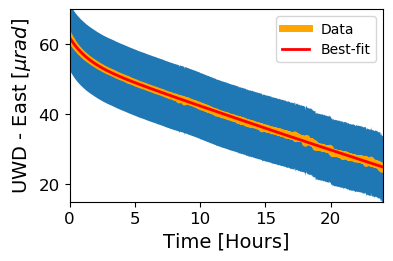

0.00022948079588987617

In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  7 23:49:54 2020

@author: aroman
"""

import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import csv 
import pickle
from PCA_projection_tilt import *
from scipy.optimize import curve_fit

def double_exp(t,A,B,E,x1,xi2):
    y  = A * np.exp(-x1*t) + B * np.exp(-xi2*t)  - E
    return y

def format_gps(A):
    A = A[5:]
    t = []
    d = []
    uz = []
    for i in A:
        t.append(float(i[0]))
        d.append(i[1])
        uz.append(float(i[2])) 
    t = np.array(t)
    uz = np.array(uz)
    return t,d,uz

def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end
def read_csv(filename):
  
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        A = []
        for row in readCSV:
            A.append(row)
    return A


def stick_slip(tilt_filt,dates):
  
    dist = 500
    prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
  
    return time_peaks,peaks,ind
date = '07-03-2018'

if date == '06-16-2018':
    t0 = 736861.85 # This is night of 06/16/2018
else:
    t0 = 736878.53
name = 'UWD' #Tilt station to invert
sample = 1
tend = 736910

path_data = '../data/'
stations = pickle.load(open(path_data + 'tilt_dictionary_01may.pickle','rb')) 
b, a = signal.butter(2, 0.03)
date_caldera_start = mdates.date2num(datetime.strptime('2018-05-26','%Y-%m-%d'))
date_caldera_end = mdates.date2num(datetime.strptime('2018-08-03','%Y-%m-%d'))
#tmin = 1e+7
#tmax = 0
months = mdates.MonthLocator()  # every month
fifteen_days = mdates.DayLocator(bymonthday=(1,15))  # labels every 15 day
days = mdates.DayLocator()  # every day
date_fmt = mdates.DateFormatter('%m/%d')

day_beginning = '2018-05-01' #all timeseries
day_end = '2018-08-08'
first_day = mdates.date2num(datetime.strptime(day_beginning,'%Y-%m-%d'))
last_day = mdates.date2num(datetime.strptime(day_end,'%Y-%m-%d'))

east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
'''
Extract staff that is not nan
'''
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]
time = time[::sample]
east = east[::sample]
north = north[::sample]
north = north[time > t0]
east = east[time > t0]
time = time[time > t0]
north = north[time < tend]
east = east[time < tend]
time = time[time < tend]
time = time - t0
east = east - east[0]
north = north - north[0]
timebase = np.linspace(0,1,1000)
north_filt = signal.filtfilt(b, a,north)
time_peaks,peaks,ind = stick_slip(north_filt,time)
stack  =[]
dtiltslipnorth = []
dtiltslipeast = []
dtiltsticknorth = []
dtiltstickeast = []
teststack = []
counter = 0
for i in range(len(ind)-1):
    north_cyc =  north[ind[i]:ind[i +1]-50] -  north[ind[i]]
    if i == 0:
        north0 = north[ind[i] - 50]
    north_cyc = north_cyc - north0
    east_cyc =  east[ind[i]:ind[i +1]-50] -  east[ind[i]]
    test_cyc =  north[ind[i]:ind[i +1]-50] -  east[ind[i]]

    time_cyc = time[ind[i]:ind[i + 1]-50] - time[ind[i]]
    dtiltslipnorth.append(north[ind[i]-50])
    dtiltslipeast.append(east[ind[i]-50])
    dtiltsticknorth.append(north[ind[i]])
    dtiltstickeast.append(east[ind[i]])
    if time_cyc[-1] > 1:
        tiltint = np.interp(timebase,time_cyc,north_cyc)
        stack.append(tiltint)
        counter = counter + 1
stack = np.array(stack)
stack = np.mean(stack,axis = 0)
stackspr = np.std(stack,axis = 0)
popt, pcov = curve_fit(double_exp, timebase, stack)
fit = double_exp(timebase,*popt)
timebase = timebase*24
fig,ax = plt.subplots(nrows = 1 ,ncols = 1,figsize = onepltsize)
ax.plot(timebase,stack,'orange',linewidth = 5)
ax.plot(timebase,fit,'red',linewidth = 2)

ax.fill_between(timebase,stack-stackspr,stack +stackspr)
ax.set_xlim([0,24])
ax.set_ylim([15,70])
ax.set_xlabel('Time [Hours]',fontsize = 14)
ax.set_ylabel('UWD - East [$\mu rad$]',fontsize = 14)
ax.tick_params(labelsize = 12)
ax.legend(['Data','Best-fit'])
plt.show()
plt.savefig(path_figs +'stack.pdf')
counter
popt[-3]*1e-6

# Time series examples

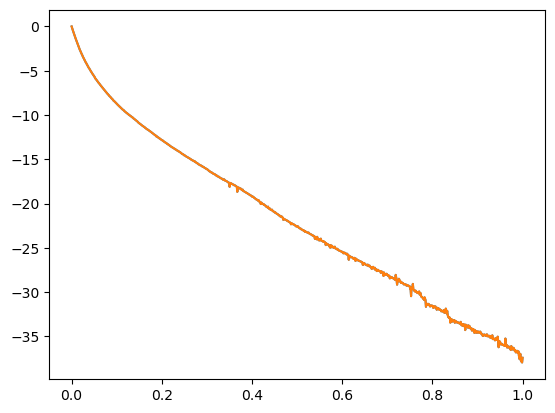

([<matplotlib.lines.Line2D at 0x116e0ee80>], None)

In [43]:
plt.plot(timebase,stack),plt.show()


In [47]:
golden_ratio

1.618

Ending! No more underpressure available to drag the piston down 0.895973516617606
Phi is  0.19607843137254902
Psi is 0.00842675159235669


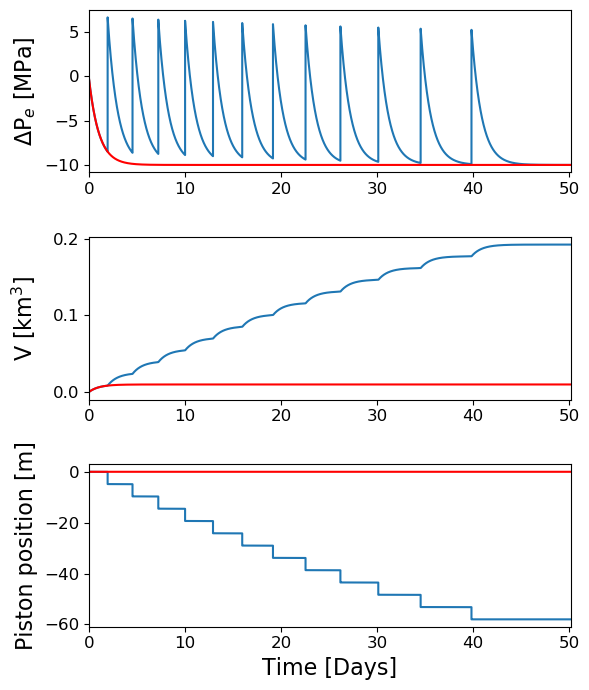

In [101]:
import sys
sys.path.insert(1,'model/')
from solvers_piston import *

x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+9
k = 1.e+9
#Piston geometrical parameters
Rp = 1e+3
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 3e+2
l = 3e+4
#Friction properties
c0 = 8.5e+6
fric_coef = 0.01
Fs = c0 * S
R5 = 0.10
Fd = Fs * R5
#Driving pressure
Pl =1e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
time,DeltaP,x,velocity,vol_out = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
p0 = 0e+6
tcol = -1/tc * np.log((-c0 +Pl) / (p0 + Pl))

timenocol = np.linspace(0,tcol,1000)
DeltaP_nocol = (Pl + p0) * np.exp(-tc *timenocol) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * timenocol))
x_nocol = np.zeros(len(timenocol))
DeltaP = np.concatenate((DeltaP_nocol,DeltaP))
x = np.concatenate((x_nocol,x))
vol_out = vol_out + V_nocol[-1]
vol_out = np.concatenate((V_nocol,vol_out))
time = time + timenocol[-1]
time = np.concatenate((timenocol,time))
DeltaP_nocol = (Pl + p0) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * time))

DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
timenocol = timenocol / (3600 * 24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 16)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[0].tick_params(labelsize = 12)
ax[0].plot(time,DeltaP_nocol,'r')
ax[1].plot(time,vol_out)
ax[1].plot(time,V_nocol,'r')
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 16)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])

ax[2].plot(time,x)
ax[2].plot(time,np.zeros(len(time)),'r')
ax[2].set_xlabel('Time [Days]',fontsize= 16)
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('Piston position [m]',fontsize= 16)

ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
plt.savefig(path_figs + 'synthetic_friction.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)


In [102]:
phi

0.19607843137254902

In [120]:
import sys
sys.path.insert(1,'model/')
from solvers_piston import *

x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+9
k = 1.e+9
#Piston geometrical parameters
Rp = 5e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 3e+2
l = 3e+4
#Friction properties
c0 = 8.0e+6
fric_coef = 0.01
Fs = c0 * S
R5 = 1.0
Fd = Fs * R5
#Driving pressure
Pl =1.5e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
time,DeltaP,x,velocity,vol_out = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
p0 = 0
tcol = -1/tc * np.log((-c0 +Pl) / (p0 + Pl))

timenocol = np.linspace(0,tcol,1000)
DeltaP_nocol = (Pl + p0) * np.exp(-tc *timenocol) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * timenocol))
x_nocol = np.zeros(len(timenocol))
DeltaP = np.concatenate((DeltaP_nocol,DeltaP))
x = np.concatenate((x_nocol,x))
vol_out = vol_out + V_nocol[-1]
vol_out = np.concatenate((V_nocol,vol_out))
time = time + timenocol[-1]
time = np.concatenate((timenocol,time))
DeltaP_nocol = (Pl + p0) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * time))

DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
timenocol = timenocol / (3600 * 24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 16)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[0].tick_params(labelsize = 12)
ax[0].plot(time,DeltaP_nocol,'r')
ax[1].plot(time,vol_out)
ax[1].plot(time,V_nocol,'r')
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 16)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])

ax[2].plot(time,x)
ax[2].plot(time,np.zeros(len(time)),'r')
ax[2].set_xlabel('Time [Days]',fontsize= 16)
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('Piston position [m]',fontsize= 16)

ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
plt.savefig(path_figs + 'synthetic_topo.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)


IndexError: index 0 is out of bounds for axis 0 with size 0

Ending! No more underpressure available to drag the piston down 0.18717669218476707
Phi is  10.625
Psi is 0.11703821656050957


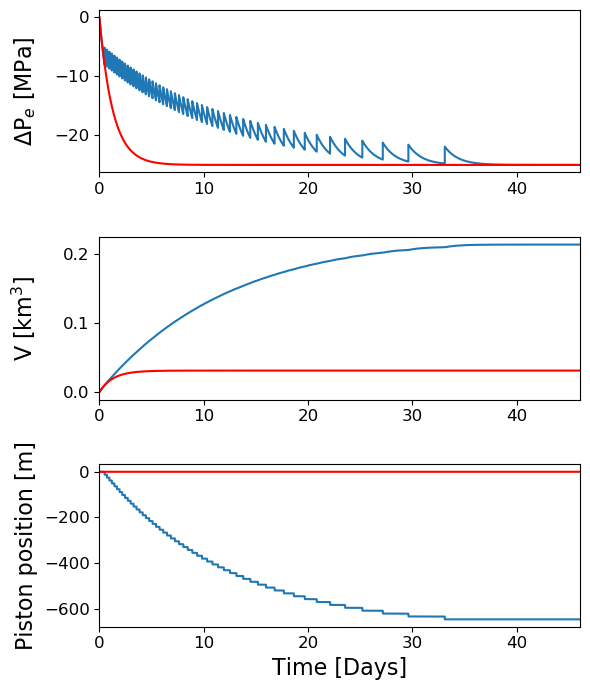

In [119]:
import sys
sys.path.insert(1,'model/')
from solvers_piston import *

x0 = 0
g = 9.8
rho = 2700
#chamber and elasticity
V0= 1e+9
k = 8.e+8
#Piston geometrical parameters
Rp = 3e+2
hp = 5e+2
S = 3.14 * Rp**2
Vp = S * hp
m = rho * Vp
#Conduit and mama properties
a = 4.
mu = 3e+2
l = 3e+4
#Friction properties
c0 = 8.0e+6
fric_coef = 0.01
Fs = c0 * S
R5 = 0.8
Fd = Fs * R5
#Driving pressure
Pl =2.5e+7
pstar = c0
tstar = ((m*V0) / (k* S**2))**0.5
xstar = Fs*V0/(k*S**2)
qstar = Fs *(V0/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V0 /(k*S)
R2 = (m * k / V0)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V0)
time,DeltaP,x,velocity,vol_out = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
p0 = 0
tcol = -1/tc * np.log((-c0 +Pl) / (p0 + Pl))

timenocol = np.linspace(0,tcol,1000)
DeltaP_nocol = (Pl + p0) * np.exp(-tc *timenocol) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * timenocol))
x_nocol = np.zeros(len(timenocol))
DeltaP = np.concatenate((DeltaP_nocol,DeltaP))
x = np.concatenate((x_nocol,x))
vol_out = vol_out + V_nocol[-1]
vol_out = np.concatenate((V_nocol,vol_out))
time = time + timenocol[-1]
time = np.concatenate((timenocol,time))
DeltaP_nocol = (Pl + p0) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(p0 + Pl) * (1 - np.exp(-tc * time))

DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
timenocol = timenocol / (3600 * 24)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (6,7))
ax[0].plot(time,DeltaP)
#ax[0].plot(time,DeltaP_nocol)
ax[0].set_ylabel('$\Delta$P$_e$ [MPa]',fontsize= 16)
ax[0].tick_params(labelsize = 12)
ax[0].set_xlim([0,time[-1]])
ax[0].tick_params(labelsize = 12)
ax[0].plot(time,DeltaP_nocol,'r')
ax[1].plot(time,vol_out)
ax[1].plot(time,V_nocol,'r')
#ax[1].plot(time,V_nocol)
ax[1].set_ylabel('V [km$^3$]',fontsize= 16)
ax[1].tick_params(labelsize = 12)
ax[1].set_xlim([0,time[-1]])

ax[2].plot(time,x)
ax[2].plot(time,np.zeros(len(time)),'r')
ax[2].set_xlabel('Time [Days]',fontsize= 16)
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('Piston position [m]',fontsize= 16)

ax[2].set_xlim([0,time[-1]])
fig.align_ylabels(ax[:])
plt.tight_layout()
plt.savefig(path_figs + 'synthetic_psi.pdf')
DeltaP[0],DeltaP_nocol[0]
phi = ((Pl - c0) / (c0 - Fd/S))
print('Phi is ',phi)
print('Psi is', R1)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


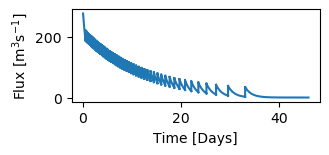

In [133]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3.2,1.2))
ax.plot(time[:-1],np.diff(vol_out)*1e+9/np.diff(time*3600*24))
ax.set_xlabel('Time [Days]')
ax.set_ylabel('Flux [m$^3$s$^{-1}$]')
plt.savefig(path_figs + 'synthetic_flux.pdf')


In [19]:
def get_data_segment(date_start,date_end,dates):
    #extract data between to dates expresses in human format
    number_start = mdates.date2num(datetime.strptime(date_start,'%Y-%m-%d'))
    number_end = mdates.date2num(datetime.strptime(date_end,'%Y-%m-%d'))
    ind = (dates>number_start) & (dates<number_end)
    return ind,number_start,number_end

def plot_stick_slip(tilt_filt,dates,cald_start,station,fmt,majloc,minloc):
    if station == 'SDH':
        dist = 400
        prom = 7
    else:
        dist = 500
        prom = 10
        
    ind, _ = signal.find_peaks(tilt_filt,distance = dist,prominence= prom)
    time_peaks = dates[ind]
    peaks = tilt_filt[ind]
    min_peaks = []
    time_min_peaks = []
    for i in range(len(ind)-1):
        y = tilt_filt[ind[i]:ind[i+1]]
        x = dates[ind[i]:ind[i+1]]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        print('Number of collapses: ',len(time_peaks))

    print(ind)
    if len(ind)>0:
        y = tilt_filt[ind[-1]:]
        x = dates[ind[-1]:]
        minimum = np.min(y)
        min_peaks.append(minimum)
        time_min_peaks.append(x[np.where(y==minimum)][0])
        peaks = np.array(peaks)
        min_peaks =np.array(min_peaks[:-1])
        time_min_peaks = np.array(time_min_peaks[:-1])
        time_peaks = np.array(time_peaks)
        min_peaks = min_peaks[time_min_peaks > cald_start]
        time_min_peaks = time_min_peaks[time_min_peaks > cald_start]
        peaks = peaks[time_peaks > cald_start]
        time_peaks = time_peaks[time_peaks > cald_start]
        amp = peaks - min_peaks
        print('Number of collapses: ',len(time_peaks))
        fig = plt.figure()
        ax.plot(dates,tilt_filt)
        ax.plot(time_peaks,peaks,'ro-')
        ax.plot(time_min_peaks,min_peaks,'bo-')
        ax.xaxis.set_major_formatter(fmt)
        ax.xaxis.set_major_locator(majloc)
        ax.xaxis.set_minor_locator(minloc)
        ax.set_xlim([beginning,end])
        plt.show()
    return np.diff(time_min_peaks),time_min_peaks[:-1],peaks,min_peaks
name ='UWD'

east = stations[name]['east']
north = stations[name]['north']
time = stations[name]['time']
'''
Extract staff that is not nan
'''
indices = (np.isnan(north) == False) & (np.isnan(east) == False)
time = time[indices] 
east = east[indices] 
north = north[indices]

east = (east - east[0]) 
north = (north - north[0])
time = time[::1]
north = north[::1]
east = east[::1]

u1,w1,u2,w2,PCAmean = PCA_vectors(east,north) #Extract PCA vector and PCA mean
proj_max = east * u1 + north * w1
proj_min = east * u2 + north * w2
if not(name=='POO'):
    proj_max = signal.filtfilt(b, a, proj_max)
dt_stick,time_collapses,pstick,pslip = plot_stick_slip(proj_max,time,date_caldera_start,name,date_fmt,months,days)
dt_stick

NameError: name 'stations' is not defined

<Figure size 432x288 with 0 Axes>

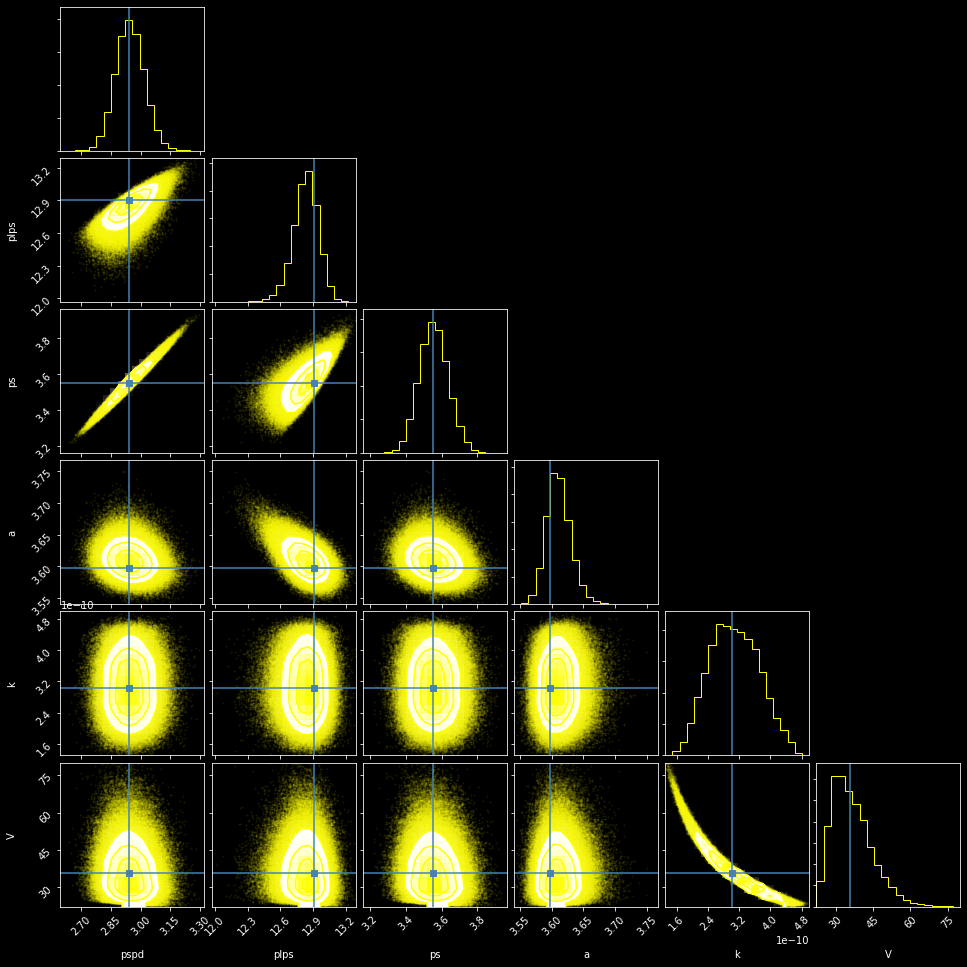

In [28]:
pathgg_results = 'inversion/dynamical_model/UWD/'
filename = 'mu_100_Rp_700.pickle'
rho = 2600
g = 9.8
lame = 1e+9
poisson = 0.25
mu = 100
l = 4e+4

results =pickle.load(open(pathgg_results + filename,'rb'))
panda_trace = pm.backends.tracetab.trace_to_dataframe(results['trace'])
panda_trace['V'] = (panda_trace['V']) /1e+9 
panda_trace['k'] = 1 / ((panda_trace['k']))
panda_trace['ps'] = panda_trace['ps'] / 1e+6 
panda_trace['pspd'] = panda_trace['ps']   - panda_trace['pspd'] / 1e+6    
panda_trace['plps'] = panda_trace['plps'] / 1e+6                        #Change this if chainging k or volume
panda_trace['plps'] = panda_trace['plps'] + panda_trace['ps']                        #Change this if chainging k or volume

plt.figure(1)
corner.corner( panda_trace[['pspd','plps','ps','a','k','V']],color = 'yellow',
              truths = [+results['MAP']['ps']/1e+6 - results['MAP']['pspd']/1e+6,results['MAP']['plps']/1e+6 +results['MAP']['ps']/1e+6 ,results['MAP']['ps']/1e+6,
                        results['MAP']['a'],1 / (results['MAP']['k']),(results['MAP']['V'])/1e+9])
plt.savefig(path_figs + 'inversions_dynamical_stats.pdf')


/anaconda3/envs/pyMC/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -153.58, ||grad|| = 0.19618: 100%|██████████| 108/108 [00:00<00:00, 2059.42it/s] 


0.1854987160129047


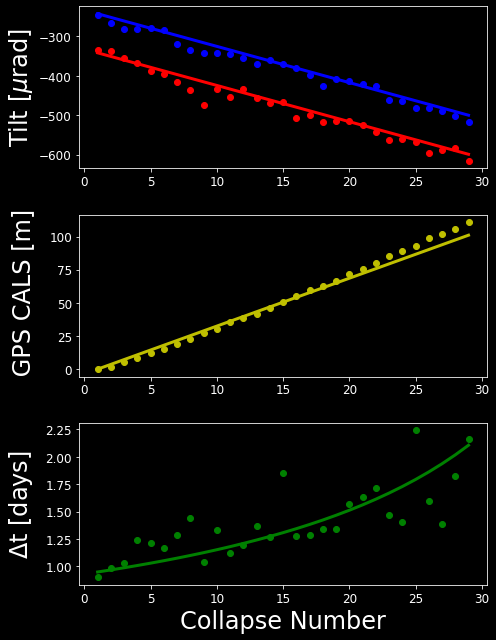

In [38]:
### import numpy as np
import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import pymc3 as pm
import pickle as pickle
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,'sar/')
from coord_conversion import *


g = 9.8
rho = 2700
#chamber and elasticity
#Elastic properties crust
poisson = 0.25
lame = 1e+9
#Position of the chamber
#Piston geometrical parameters
Rp = 7e+2
S = 3.14 * Rp**2
#Conduit Properties
l = 4e+4
mu =  100
tiltName = 'UWD'
filename = 'DataForInversion' + tiltName + '.pickle'
data = pickle.load(open('inversion/dynamical_model/' + filename,'rb'))
tilt_stick = data['tilt_stick'] * 1e-6
tilt_slip =  data['tilt_slip'] * 1e-6
tilt_std = data['tilt_std'] * 1e-6
dt_stick = data['dt_stick'] * 3600 * 24 
x = -data['gps']
dt_std = 60
x_std =1
xSource = 84
ySource =  82
depth_estimate = 3200
ref_point = np.array([-155.274,19.395])  # Ref point is alway CRIM
xy = llh2local(data['LonLat'],ref_point) *1000
radial_distance = ((xy[0] - xSource)**2 + (xy[1] - ySource)**2)**0.5
#radial_distance = 1000
n = np.arange(1,len(tilt_stick)+ 1 )
Nmax = len(n)
nSample = 70000
#Setup inversion
with pm.Model() as model:
    V_exp = pm.Uniform('V_exp',lower = 8,upper = 11)
    k_exp = pm.Uniform('k_exp',lower = 8, upper = 11)
    V = pm.Deterministic('V',10**V_exp)
    k = pm.Deterministic('k',10**k_exp)
    ps = pm.Uniform('ps',lower=1e+6,upper=2e+7)   
    pspd = pm.Uniform('pspd',lower=1e+5,upper=2e+7)
    a = pm.Uniform('a',lower=1,upper=10)
    depth = pm.Normal('depth',mu = depth_estimate, sigma = 500)
    R = (radial_distance**2 + depth**2)**0.5 # Change this if including deepth in the inversion
    R1 = rho * g * V /(k * S)                           #Change this if chainging k or volume

    low_bound = 2 * Nmax * R1 / (1 + R1) * pspd
    up_bound = 2 * (Nmax + 20) * R1 / (1 + R1) * pspd
    plps = pm.Uniform('plps',lower=low_bound,upper=up_bound)
    phi = plps / pspd
    tau =  8 * mu *l * V/ (3.14 * a**4 * k)               #Change this if inverting k or volume
    #Model set-up
    dt_mod = -tau * pm.math.log(((1 + R1) * phi - 2 * n * R1 ) / (((1 + R1) *phi - 2 *(R1*(n -1) -1))))
    x_mod = R1 / (rho * g) * pspd / (1 + R1) * n
    pslip_mod = -ps -rho * g * x_mod
    pstick_mod = pslip_mod + 2 * pspd/ (1 + R1)

#    tilt_mod = (-ps_mod * V_mod  -rho * g * V_mod * x) * tilt_coeff_inversion 
    tilt_coeff =  9./(4*3.14) * V * (1 - poisson)/lame* radial_distance * depth/(R**5) #Change this if inverting volume or depth
    tilt_slip_mod = pslip_mod * tilt_coeff
    tilt_stick_mod =pstick_mod * tilt_coeff
    
    #Posterio
    Tst_obs = pm.Normal('Tst_obs', mu=tilt_stick_mod, sigma = tilt_std, observed=tilt_stick)
    Tsl_obs = pm.Normal('Tsl_obs', mu=tilt_slip_mod, sigma = tilt_std, observed=tilt_slip)
    dt_obs = pm.Normal('dt_obs', mu = dt_mod, sigma = 10000, observed = dt_stick)
    x_obs = pm.Normal('x_obs', mu = x_mod, sigma = x_std, observed=x) 
map_est = pm.find_MAP(model=model)
depth = map_est['depth']
k = map_est['k']
V = map_est['V']
a = map_est['a']
ps = map_est['ps']
pspd = map_est['pspd']
plps = map_est['plps']
phi = plps / pspd
tau =  8 * mu *l * V/ (3.14 * a**4 * k) 
R = (radial_distance**2 + depth**2)**0.5 # Change this if including deepth in the inversion
R1 = rho * g * V /(k * S)     
dt_stick_mod = -tau * np.log(((1 + R1) * phi - 2 * n * R1 ) / (((1 + R1) *phi - 2 *(R1*(n -1) -1)))) 
x_mod = R1 / (rho * g) * pspd / (1 + R1) * (n - 1)
pslip_mod = -ps -rho * g * x_mod
pstick_mod = pslip_mod + 2 * pspd/ (1 + R1)
tilt_coeff =  9./(4*3.14) * V* (1 - poisson)/lame* radial_distance * depth/(R**5) #Change this if inverting volume or depth
tilt_slip_mod = pslip_mod * tilt_coeff
tilt_stick_mod =pstick_mod * tilt_coeff
fig,ax = plt.subplots(nrows =3,ncols = 1,figsize= (7,9))
ax[0].plot(n,tilt_slip *1e+6,'ro')
ax[0].plot(n,tilt_slip_mod *1e+6,'r',linewidth = 3)
ax[0].plot(n,tilt_stick* 1e+6,'bo')
ax[0].plot(n,tilt_stick_mod *1e+6,'b',linewidth = 3)
ax[0].tick_params(labelsize = 12)

ax[0].set_ylabel('Tilt [$\mu$rad]',fontsize =24)
ax[1].plot(n,x,'yo')
ax[1].plot(n,x_mod,'y',linewidth = 3)
ax[1].set_ylabel(' GPS CALS [m]',fontsize =24)
ax[1].tick_params(labelsize = 12)

ax[2].plot(n,dt_stick /(3600 * 24),'o',color ='green')
ax[2].plot(n,dt_stick_mod / (3600 * 24),color ='green',linewidth = 3)
ax[2].set_ylabel('$\Delta$t [days]',fontsize =24)
ax[2].set_xlabel('Collapse Number',fontsize =24)
ax[2].tick_params(labelsize = 12)

fig.align_ylabels(ax[:])
plt.tight_layout()
plt.savefig(path_figs + 'inversions_dynamical_MAP.pdf')
print(R1)


Ending! No more underpressure available to drag the piston down 0.17180874555467218


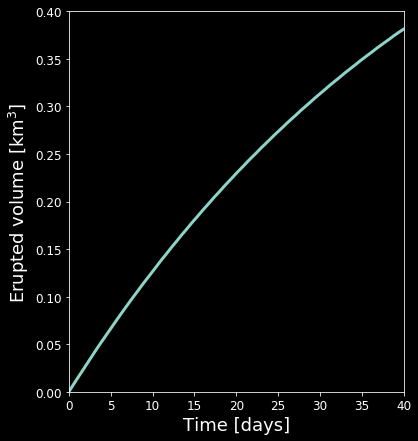

In [56]:
m = 1e+10
c0 = ps
Fs = ps * S
Fd = ps * R5
pd = ps - pspd
Pl = plps + ps
R5 = pd /ps
pstar = ps
tstar = ((m*V) / (k* S**2))**0.5
xstar = Fs*V/(k*S**2)
qstar = Fs *(V/(k*m))**0.5
Vstar = xstar * S
R1 = rho * g * V /(k*S)
R2 = (m * k / V)**0.5 *(3.14 * a**4 )/(8* mu * l* S) 
R3 = Pl / Fs * S
R4 = -1
x0 = x0/xstar
tc = 3.14 * a**4 *k/ (8* mu * l * V)
DeltaP,x,velocity,N_cycle,time,t_slip,dt_slip,dx_slip,slip_duration,q_out,vol_out,p_slip,dp_slip = isostatic_piston(x0,R1,R2,R3,R4,R5)
DeltaP = DeltaP * pstar
dx_slip = dx_slip * xstar
x = x * xstar
x = -x
vol_out = vol_out* Vstar
time = time * tstar
DeltaP_nocol = (Pl + DeltaP[0]) * np.exp(-tc *time) - Pl
V_nocol = V0/k *(DeltaP[0] + Pl) * (1 - np.exp(-tc * time))
DeltaP = DeltaP / 1e+6
DeltaP_nocol = DeltaP_nocol / 1e+6
vol_out = vol_out / 1e+9
V_nocol = V_nocol / 1e+9
time = time / (3600 *24)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,7))
ax.plot(time,vol_out,linewidth = 3)
ax.set_ylabel('Erupted volume [km$^3$]',fontsize= 18)
ax.tick_params(labelsize = 12)
ax.tick_params(labelsize = 12)
ax.set_xlabel('Time [days]',fontsize= 18)
ax.set_xlim([0,40])
ax.set_ylim([0,0.4])
plt.savefig(path_figs + 'volume_erupted_MAP.pdf')


In [59]:
N_cycle

49

In [ ]:
llclon = np.min(lon_DEM)
llclat = np.min(lat_DEM)
urclon = np.max(lon_DEM)
urclat = np.max(lat_DEM)
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
#im_dummy = ax2.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 1.0 ,cmap = 'Blues_r',vmin = -16, vmax =0)
blow, alow = signal.butter(2, 1e-4)
bhigh, ahigh = signal.butter(2, 1e-4,'high')
b, a = signal.butter(2, 0.03)
fig1 = plt.figure(1,figsize=(7,5))
map = Basemap(projection='tmerc', 
              lat_0=(llclat+urclat) * 0.5, lon_0=(llclon+urclon) * 0.5,
              llcrnrlon=llclon, 
              llcrnrlat=llclat, 
              urcrnrlon=urclon, 
              urcrnrlat=urclat)
lon_downsamp_map,lat_downsamp_map = map(lon_downsamp,lat_downsamp)
im1 = map.imshow(rgb,origin = 'upper',rasterized =True)
im2 = map.scatter(lon_downsamp_map,lat_downsamp_map,s = 20,c = los_downsamp*100,alpha = 0.6 ,cmap = 'Blues_r',vmin = -16, vmax =0)
cbar = map.colorbar(im_dummy,shrink = 0.2,alpha = 1,ticks=[ 0,-7.5,-15])
cbar.ax.set_yticklabels(['0', '-7.5','-15']) 
cbar.set_label('LOS displacements [cm]',fontsize = 18)
cbar.solids.set_rasterized(True)


counter = 0
for name in list_station:
    x,y = map(stations[name]['lon_lat'][0],stations[name]['lon_lat'][1])

    east = stations[name]['east']
    north = stations[name]['north']
    time = stations[name]['time']
    '''
    Extract staff that is not nan
    '''
    npix =  750 # extension (in pixel) of the arrows
    indices = (np.isnan(north) == False) & (np.isnan(east) == False)
    time = time[indices] 
    east = east[indices] 
    north = north[indices] 
    east = (east - east[0]) 
    north = (north - north[0])
    time = time[::1]
    north = north[::1]
    east = east[::1]
    north_low = signal.filtfilt(blow, alow,north)
    east_low = signal.filtfilt(blow, alow,east)
    north_high = signal.filtfilt(bhigh, ahigh,north)
    east_high = signal.filtfilt(bhigh, ahigh,east)
    north_high = signal.filtfilt(b, a,north_high)
    east_high = signal.filtfilt(b, a,east_high)
    u1_low,w1_low,u2,w2,PCAmean = PCA_vectors(east_low,north_low) #Extract PCA vector and PCA mean
    u1_high,w1_high,u2,w2,PCAmean = PCA_vectors(east_high,north_high) #Extract PCA vector and PCA mean

    plt.figure(1)
    draw_vector([x,y],[x +u1_low*npix,y + w1_low*npix ],'orange')
    draw_vector([x,y],[x -u1_low*npix,y - w1_low*npix ],'orange')
    draw_vector([x,y],[x +u1_high*npix,y + w1_high*npix ],'orange')
    draw_vector([x,y],[x -u1_high*npix,y - w1_high*npix ],'orange')
    if not (name == 'UWE'):             #UWD and UWE are on the same site, plotting only UWE
        map.plot(x,y,'ko',markersize = 5)
    if (name == 'SDH'):
        plt.text(x-1000,y+800,name,color = 'black',fontsize = 6,fontweight = 'bold')
    else:
        plt.text(x+500,y+150,name,color = 'black',fontsize = 6,fontweight = 'bold')
    
    counter = counter + 1
lon_crim  = -155.274
lat_crim  = 19.395
lat_npit = 19.412
lon_npit = -155.281
x_crim,y_crim = map(lon_crim,lat_crim)
x_npit,y_npit = map(lon_npit,lat_npit)

plt.text(x_crim + 200,y_crim+200,'CRIM',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_crim,y_crim,'k*')
plt.text(x_npit + 200,y_npit+200,'NPIT',color = 'black',fontweight = 'bold',fontsize = 6)
map.plot(x_npit,y_npit,'k*')
plt.tight_layout()
plt.savefig(path_figs + 'interferogram_tilt.pdf',dpi = 800)

In [ ]:
u1